# CHAPTER 2.8

### data augmentation to improve performance with the tf.data and tf.image APIs

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

Same steps with previous notebook...

In [3]:
SEED = 999
np.random.seed(SEED)

base_path = (pathlib.Path.home() / '.keras' / 'datasets' /
             '101_ObjectCategories')
images_pattern = str(base_path / '*' / '*.jpg')
image_paths = [*glob(images_pattern)]
image_paths = [p for p in image_paths if
               p.split(os.path.sep)[-2] != 'BACKGROUND_Google']
CLASSES = np.unique([p.split(os.path.sep)[-2]
                     for p in image_paths])

train_paths, test_paths = train_test_split(image_paths,
                                           test_size=0.2,
                                           random_state=SEED)

In [4]:
images_pattern

'C:\\Users\\Zeki\\.keras\\datasets\\101_ObjectCategories\\*\\*.jpg'

In [5]:
CLASSES

array(['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion',
       'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver',
       'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha',
       'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan',
       'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face',
       'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup',
       'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly',
       'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry',
       'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone',
       'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter',
       'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp',
       'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly',
       'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi',
       'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid',
       'revolver', 'rhino', 'r

In [6]:
def load_image_and_label(image_path, target_size=(64, 64)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, np.float32)
    image = tf.image.resize(image, target_size)

    label = tf.strings.split(image_path, os.path.sep)[-2]
    label = (label == CLASSES)  # One-hot encode.
    label = tf.dtypes.cast(label, tf.float32)

    return image, label

In [7]:
def prepare_dataset(data_pattern):
    return (tf.data.Dataset
            .from_tensor_slices(data_pattern)
            .map(load_image_and_label,
                 num_parallel_calls=AUTOTUNE))

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024
train_dataset = (prepare_dataset(train_paths)
                 .batch(BATCH_SIZE)
                 .shuffle(buffer_size=BUFFER_SIZE)
                 .prefetch(buffer_size=BUFFER_SIZE))
test_dataset = (prepare_dataset(test_paths)
                .batch(BATCH_SIZE)
                .prefetch(buffer_size=BUFFER_SIZE))

In [12]:
len(train_dataset)

109

In [13]:
train_dataset

<PrefetchDataset shapes: ((None, 64, 64, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [14]:
def build_network(width, height, depth, classes):
    input_layer = Input(shape=(width, height, depth))

    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               padding='same')(input_layer)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=64,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters=64,
               kernel_size=(3, 3),
               padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.25)(x)

    x = Flatten()(x)
    x = Dense(units=512)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(rate=0.5)(x)

    x = Dense(units=classes)(x)
    output = Softmax()(x)

    return Model(input_layer, output)

In [15]:
EPOCHS = 40
model = build_network(64, 64, 3, len(CLASSES))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 32)        0         
                                                             

In [18]:
from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

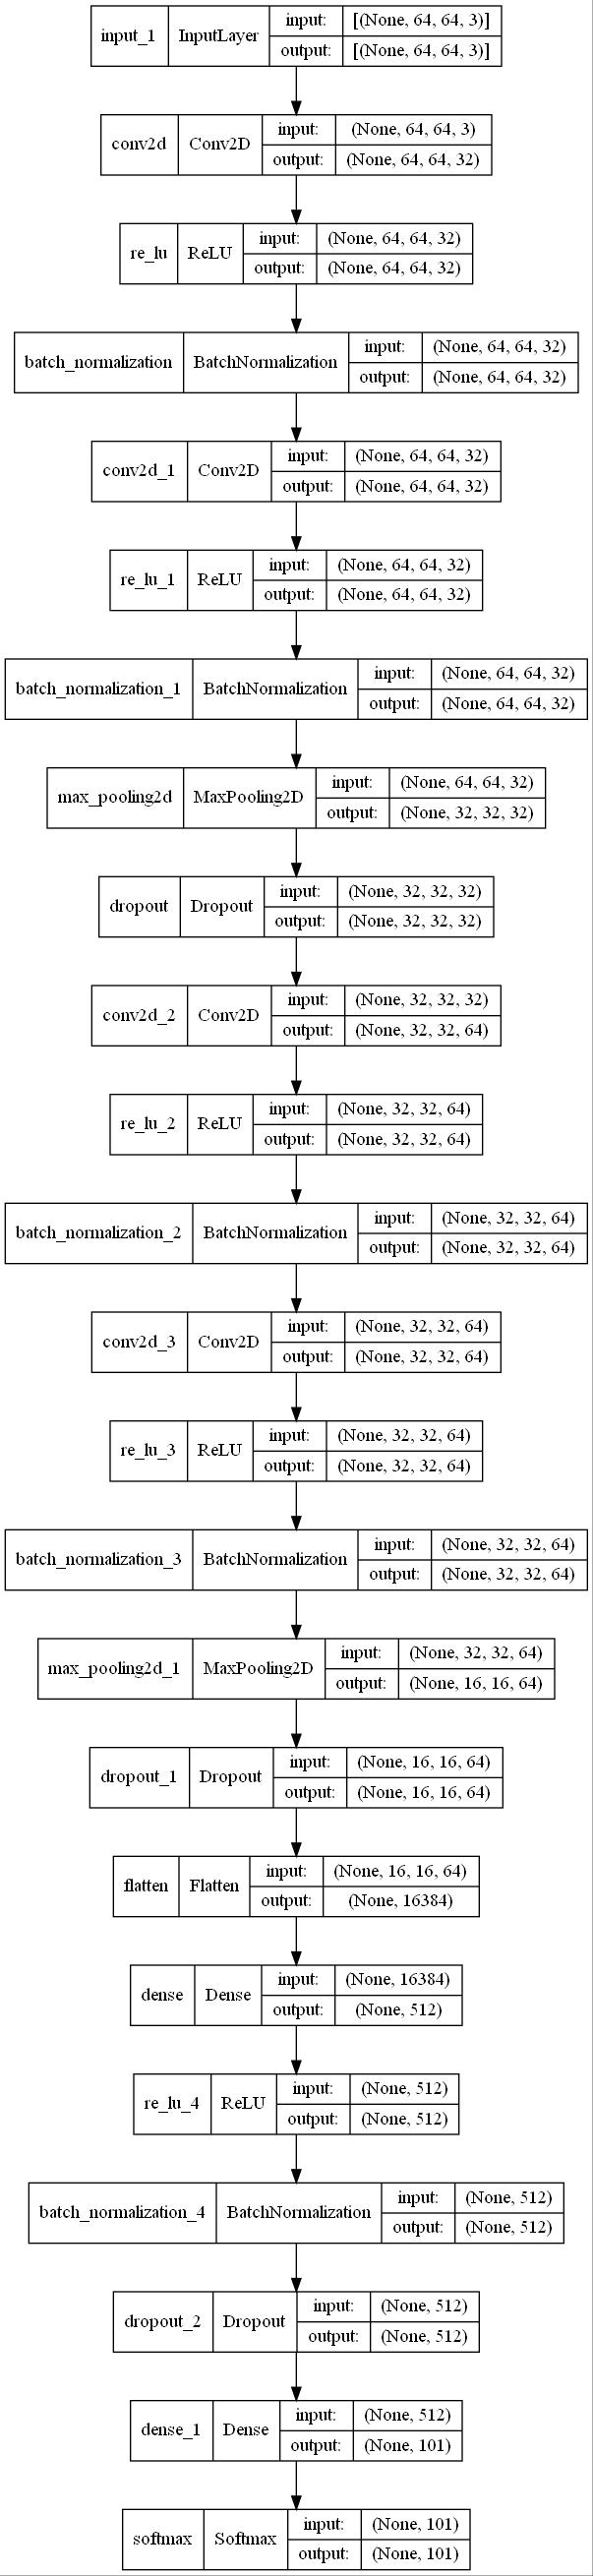

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='data_aug_10th_notebook.jpg')

In [20]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=EPOCHS)

Epoch 1/40
109/109 [==============================] - 17s 40ms/step - loss: 3.0329 - accuracy: 0.3952 - val_loss: 5.2598 - val_accuracy: 0.0144
Epoch 2/40
109/109 [==============================] - 6s 35ms/step - loss: 1.6248 - accuracy: 0.6233 - val_loss: 4.4242 - val_accuracy: 0.1083
Epoch 3/40
109/109 [==============================] - 6s 35ms/step - loss: 0.9121 - accuracy: 0.7837 - val_loss: 2.8457 - val_accuracy: 0.3790
Epoch 4/40
109/109 [==============================] - 6s 36ms/step - loss: 0.4805 - accuracy: 0.8955 - val_loss: 2.0284 - val_accuracy: 0.5294
Epoch 5/40
109/109 [==============================] - 6s 35ms/step - loss: 0.2665 - accuracy: 0.9447 - val_loss: 1.5908 - val_accuracy: 0.6273
Epoch 6/40
109/109 [==============================] - 6s 35ms/step - loss: 0.1436 - accuracy: 0.9752 - val_loss: 1.6518 - val_accuracy: 0.6331
Epoch 7/40
109/109 [==============================] - 6s 37ms/step - loss: 0.0992 - accuracy: 0.9824 - val_loss: 1.5906 - val_accuracy: 0.640

In [21]:
result = model.evaluate(test_dataset)
print(f'Test accuracy: {result[1]}')

28/28 [==============================] - 1s 19ms/step - loss: 1.9478 - accuracy: 0.6446
Test accuracy: 0.6445852518081665


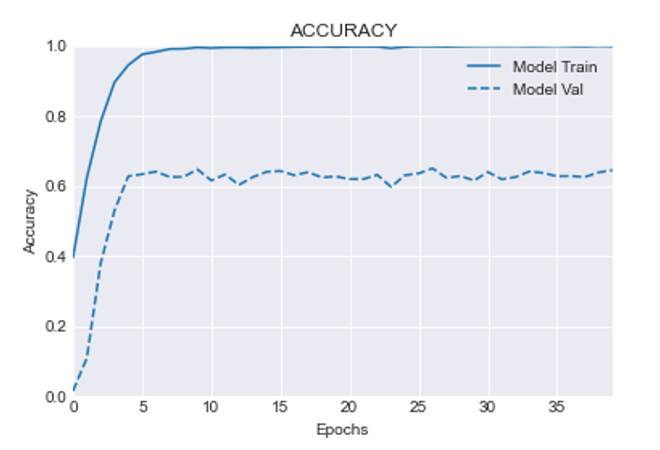

In [25]:
len(test_dataset)

28

In [26]:
len(train_paths)

6941

In [27]:
len(test_paths)

1736

!! Because of the batch size is 64... 6941/64 is length of training set and it is 109!!! and also 1736/64 is length of test set and it is 28 !!

In [22]:
def plot_model_history(model_history, metric, plot_name):
    plt.style.use('seaborn-darkgrid')
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({'Model': model_history}, metric=metric)

    plt.title(f'{metric.upper()}')
    plt.ylim([0, 1])

    plt.savefig(f'{plot_name}.png')
    plt.close()

In [24]:
plot_model_history(history, 'accuracy', 'normal_10')

NOW, WITH DATA AUGMENTATION....

In [29]:
def augment(image, label):
    image = tf.image.resize_with_crop_or_pad(image, 74, 74)
    image = tf.image.random_crop(image, size=(64, 64, 3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)

    return image, label

In [30]:
train_dataset = (prepare_dataset(train_paths)
                 .map(augment, num_parallel_calls=AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .shuffle(buffer_size=BUFFER_SIZE)
                 .prefetch(buffer_size=BUFFER_SIZE))
test_dataset = (prepare_dataset(test_paths)
                .batch(BATCH_SIZE)
                .prefetch(buffer_size=BUFFER_SIZE))

In [31]:
train_dataset

<PrefetchDataset shapes: ((None, 64, 64, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [32]:
len(train_dataset)

109

In [33]:
model = build_network(64, 64, 3, len(CLASSES))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=EPOCHS)

Epoch 1/40
109/109 [==============================] - 7s 36ms/step - loss: 3.6432 - accuracy: 0.2926 - val_loss: 5.3766 - val_accuracy: 0.1060
Epoch 2/40
109/109 [==============================] - 6s 35ms/step - loss: 2.6704 - accuracy: 0.4224 - val_loss: 5.6362 - val_accuracy: 0.0622
Epoch 3/40
109/109 [==============================] - 6s 36ms/step - loss: 2.1722 - accuracy: 0.5002 - val_loss: 3.8354 - val_accuracy: 0.2569
Epoch 4/40
109/109 [==============================] - 6s 37ms/step - loss: 1.8688 - accuracy: 0.5600 - val_loss: 2.4159 - val_accuracy: 0.4447
Epoch 5/40
109/109 [==============================] - 6s 37ms/step - loss: 1.6250 - accuracy: 0.6048 - val_loss: 1.8724 - val_accuracy: 0.5755
Epoch 6/40
109/109 [==============================] - 7s 37ms/step - loss: 1.4943 - accuracy: 0.6318 - val_loss: 1.7564 - val_accuracy: 0.6210
Epoch 7/40
109/109 [==============================] - 6s 36ms/step - loss: 1.3782 - accuracy: 0.6568 - val_loss: 1.5354 - val_accuracy: 0.6382

In [34]:
result = model.evaluate(test_dataset)
print(f'Test accuracy: {result[1]}')
plot_model_history(history, 'accuracy', 'augmented_10')

28/28 [==============================] - 1s 23ms/step - loss: 1.4982 - accuracy: 0.6935
Test accuracy: 0.6935483813285828


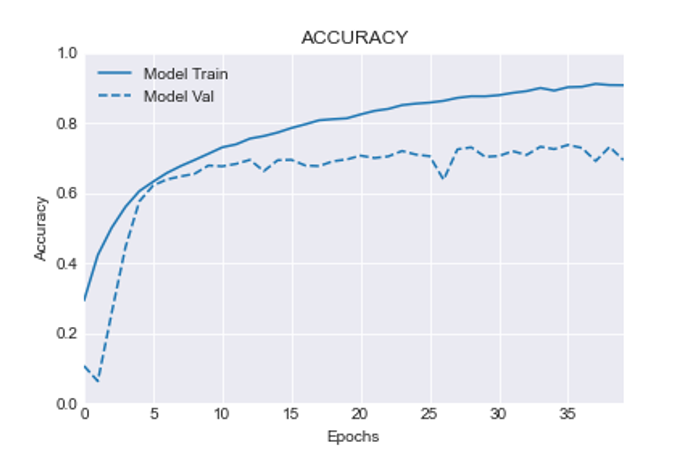

 !! <font color=blue>*the gap between the training and validation accuracy curves is noticeably smaller, which suggests a regularization effect coming out from the application of data augmentation*</font> !!

<font color=blue>*TEXT_HERE*</font>... for colorful italic text